In part 1, we are going to train a model to detect key facial points on humans. The dataset has been found on kaggle




In [7]:
from google.colab import drive
drive.mount('/content/drive')

## Path for the dataset can be found at 
## drive/'My Drive'/'Colab Notebooks'/'U-demy - AI Program'/'Emotion AI Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
## Changing directory to where the notebook and dataset is located
%cd /content/drive/'My Drive'/'Colab Notebooks'/'U-demy - AI Program'/

/content/drive/My Drive/Colab Notebooks/U-demy - AI Program


In [9]:
## Importing all necessary TensorFlow, Keras, and general purpose data science modules
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [ ]:
## Loading up the facial key points data into pandas
facial_key_points_df = pd.read_csv('Emotion AI Dataset/data.csv')

In [ ]:
facial_key_points_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [ ]:
## Obtaining information about the dataset
facial_key_points_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [ ]:
## Checking for missing values within the dataset
facial_key_points_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [ ]:
## Ther are 2140 data points and 31 features present in th dataset
facial_key_points_df.shape

(2140, 31)

In [ ]:
## The pixels in Image are in 1D format. The actual image is of shape 96,96, so we are going to reshape the 1D array into a 2D array
facial_key_points_df['Image'] = facial_key_points_df['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96,96))

In [ ]:
facial_key_points_df['Image'][0].shape ## reshape was successful

(96, 96)

In [ ]:
facial_key_points_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,22.361617,38.034571,56.147991,29.222304,79.617523,29.656570,39.272084,29.413747,15.761707,30.452947,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,2.768804,2.654903,2.819914,2.867131,3.312647,3.627187,2.609648,2.842219,3.337901,3.644342,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,11.054589,26.521633,35.581733,15.859361,55.549929,10.522325,25.060327,16.476000,3.826243,13.224453,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,20.631964,36.569765,54.562757,27.590944,77.732395,27.658656,37.555192,27.798773,13.540535,28.268263,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,22.529600,37.876900,56.239984,29.468466,79.797607,29.753523,39.247681,29.528098,15.760876,30.333323,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,24.202338,39.401034,57.926361,31.079433,81.559651,31.763791,40.824154,31.134740,17.871569,32.661300,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,40.050971,50.002113,67.752000,40.293408,94.269957,48.823425,51.300571,39.445859,39.676082,44.857962,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


Will now be doing some visualization on the dataset

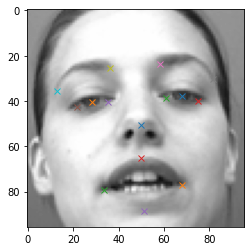

In [ ]:
## Plotting the image
i = np.random.randint(0, len(facial_key_points_df['Image']))
plt.imshow(facial_key_points_df['Image'][i], cmap='gray')

## Plotting keypoints on image
## There are 31 features in the dataset and for each object there are two columns
## x and y. That is why the step is set to 2. at each iteration we take the previous column (x [j-1])
## and the current column (y [j])
for j in range(1, 31, 2):
  plt.plot(facial_key_points_df.loc[i][j-1], facial_key_points_df.loc[i][j], 'x')

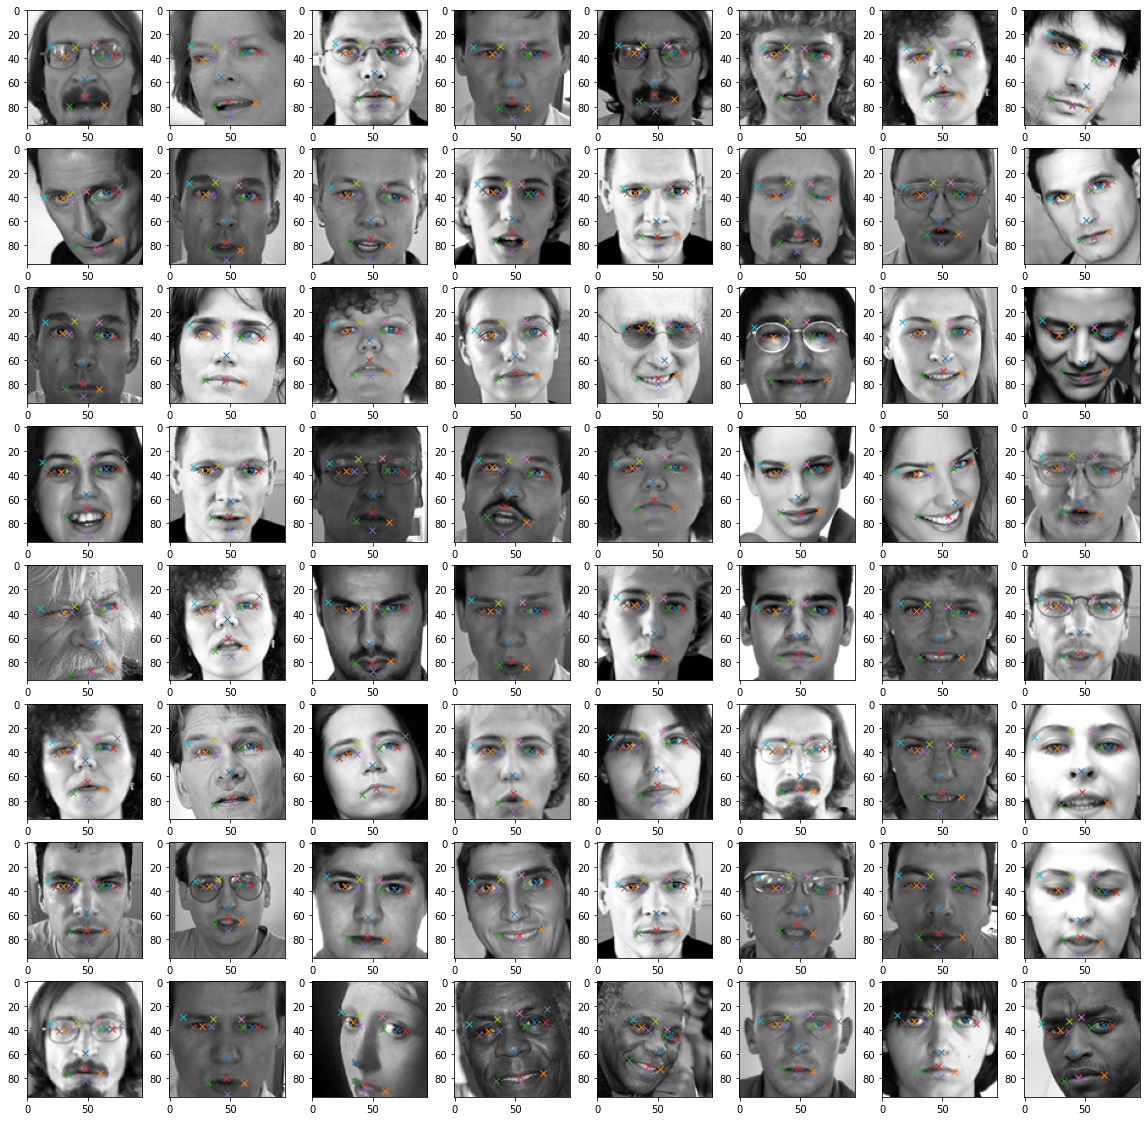

In [ ]:
fig = plt.figure(figsize=(20,20))

for i in range(64):
  image_index = np.random.randint(1, len(facial_key_points_df['Image']))
  ax = fig.add_subplot(8,8,i+1)
  image = plt.imshow(facial_key_points_df['Image'][image_index], cmap='gray')
  for j in range(1, 31, 2):
    plt.plot(facial_key_points_df.loc[image_index][j-1], facial_key_points_df.loc[image_index][j], 'x')

The key points dataset is quite small. In order for the model to learn and make accurate predictions we need to apply some image augmentation to increase the dataset and introduce new "viewports". This should increase the model accuracy by making it more robust

In [ ]:
#facial_key_points_df_copy = facial_key_points_df.copy()
import copy
facial_key_points_df_copy = copy.copy(facial_key_points_df)

In [ ]:
column_name = facial_key_points_df_copy.columns[:-1]
column_name

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [ ]:
## First augmentation technique being applied will be a horizontal flip
facial_key_points_df_copy['Image'] = facial_key_points_df_copy['Image'].apply(lambda x: np.flip(x, axis=1))

## Will need to subtract the value of the x column by the height of the image to get new coordiante location
for i in range(len(column_name)):
  if i % 2 == 0: ## x coordintes
    facial_key_points_df_copy[column_name[i]] = facial_key_points_df_copy[column_name[i]].apply(lambda x: 96. - float(x))

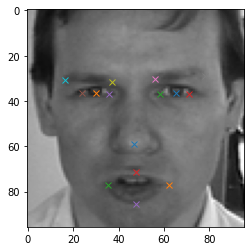

In [ ]:
## Again, visualizing the normal image and comparing it to the flipped
image_id = 150
plt.imshow(facial_key_points_df['Image'][image_id], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(facial_key_points_df.loc[image_id][j-1], facial_key_points_df.loc[image_id][j], 'x')


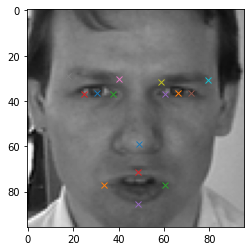

In [ ]:
plt.imshow(facial_key_points_df_copy['Image'][image_id], cmap='gray')
for j in range(1,31,2):
  plt.plot(facial_key_points_df_copy.loc[image_id][j-1], facial_key_points_df_copy.loc[image_id][j], 'x')

In [ ]:
## Will be combining the augmented dataframe and the orginal dataframe
augmented_df = np.concatenate((facial_key_points_df, facial_key_points_df_copy))

In [ ]:
augmented_df.shape ## The number of datapoints doubled, effectively giving us double the images to train on 

(4280, 31)

In [ ]:
## Will be applying vertical flip to the images
facial_key_points_df_copy = copy.copy(facial_key_points_df)

In [ ]:
## Will be applying vertical flip to the Images
facial_key_points_df_copy['Image'] = facial_key_points_df_copy['Image'].apply(lambda x: np.flip(x, axis=0))

## Will be applying the flip as well to the y-axis
for col in range(len(column_name)):
  if i % 2 == 1: ## y coordinates
    facial_key_points_df_copy[column_name[col]] = facial_key_points_df_copy[column_name[col]].apply(lambda x: 96. - float(x))

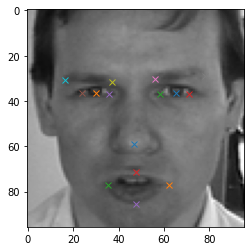

In [ ]:
## Again, visualizing the normal image and comparing it to the flipped
image_id = 150
plt.imshow(facial_key_points_df['Image'][image_id], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(facial_key_points_df.loc[image_id][j-1], facial_key_points_df.loc[image_id][j], 'x')

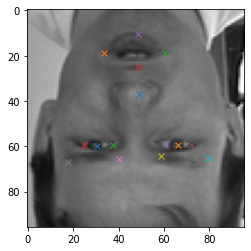

In [ ]:
plt.imshow(facial_key_points_df_copy['Image'][image_id], cmap='gray')
for j in range(1,31,2):
  plt.plot(facial_key_points_df_copy.loc[image_id][j-1], facial_key_points_df_copy.loc[image_id][j], 'x')

In [ ]:
## Combining the datasets
## REMOVED VERTICAL FLIP DUE TO IT DEGRADING THE MODELS PERFORMANCE
#augmented_df = np.concatenate((augmented_df, facial_key_points_df_copy))

In [ ]:
augmented_df.shape

(4280, 31)

In [ ]:
facial_key_points_df_copy = copy.copy(facial_key_points_df)

In [ ]:
## Will be applying a brightness filter to the images
import random
facial_key_points_df_copy['Image'] = facial_key_points_df_copy['Image'].apply(lambda x: np.clip(random.uniform(1.5,2) * x, 0.0, 255.0))

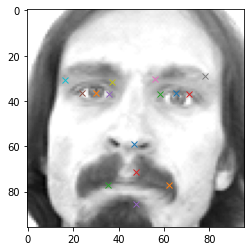

In [ ]:
## Visualize the images with different brightness
plt.imshow(facial_key_points_df_copy['Image'][0], cmap='gray')
for j in range(1,31,2):
  plt.plot(facial_key_points_df_copy.loc[image_id][j-1], facial_key_points_df_copy.loc[image_id][j], 'x')

In [ ]:
## Appending data
augmented_df = np.concatenate((augmented_df, facial_key_points_df_copy))

In [ ]:
augmented_df.shape

(6420, 31)

Data needs to be normalized for better model performance

In [ ]:
images = augmented_df[:,30]

In [ ]:
images = images/255.

In [ ]:
## Creating a numpy entry for each images with the shape 96,96,1
X = np.empty((len(images), 96, 96,1))
for items in range(len(images)):
  X[i, ] = np.expand_dims(images[i], axis = 2)

## Converting to float32 which is the type tensorflow likes
X = np.asarray(X).astype(np.float32)

In [ ]:
X.shape ## New shape of new set is (number of images, X, Y, 1)

(6420, 96, 96, 1)

In [ ]:
## Will conver the x and y coordinates to float32 as well
Y = augmented_df[:,:30] ## [rows, columns]
Y = np.asarray(Y).astype(np.float32)
Y.shape

(6420, 30)

In [ ]:
## Splitting the data up into training and testing
## X_train is inputs (images) for training and Y_train are outputs (x and y coordinates) for training
## X_test is inputs (images) for testing and Y_test are outputs (x and y coordinates) for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
X_train.shape

(5136, 96, 96, 1)

In [ ]:
X_test.shape

(1284, 96, 96, 1)

In [ ]:
print((X_test.shape[0]/X_train.shape[0]) * 100) ## Right around 11% split

25.0


Part 1: Building Deep ANN to detect key points on faces


In [ ]:
def residual_block(X, filter, stage):

  ## Convolutional Block 
  X_copy = X

  f1 , f2, f3 = filter

  ## Convolutional Block Main Path
  X = Conv2D(f1, (1,1),strides= (1,1), name= 'res_' + str(stage) + '_conv_a', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = MaxPool2D((2,2))(X) ## Reduces the size of the feature maps, reduces parameters
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size= (3,3), strides= (1,1), padding= 'same', name= 'res_' + str(stage) + '_conv_b', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name = 'bn_' + str(stage) + '_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size= (1,1), strides= (1,1),name= 'res_' + str(stage) + '_conv_c', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_conv_c')(X)

  ## Convolutional Block Short Path
  X_copy = Conv2D(f3, kernel_size= (1,1), strides= (1,1),name= 'res_' + str(stage) + '_conv_copy', kernel_initializer= glorot_uniform(seed= 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_conv_copy')(X_copy)

  ## Adding Main and Short paths together, same dimensions requried 
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  ## Identity Block 1
  X_copy = X

  ## Identity Block Main Path
  X = Conv2D(f1, (1,1),strides= (1,1), name= 'res_' + str(stage) + '_identity_1_a', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) +'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size= (3,3), strides= (1,1), padding= 'same', name= 'res_' + str(stage) + '_identity_1_b', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size= (1,1), strides= (1,1),name= 'res_' + str(stage) + '_identity_1_c', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_identity_1_c')(X)

  ## Adding Main Path output to Convolutional Block output
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  ## Identity Block 2
  X_copy = X

  ## Identity Block 2 Main Path
  X = Conv2D(f1, (1,1), strides= (1,1), name= 'res_' + str(stage) + '_identity_2_a', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size= (3,3), strides= (1,1), padding= 'same', name= 'res_' + str(stage) + '_identity_2_b', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size= (1,1), strides= (1,1),name= 'res_' + str(stage) + '_identity_2_c', kernel_initializer= glorot_uniform(seed= 0))(X)
  X = BatchNormalization(axis= 3, name= 'bn_' + str(stage) + '_identity_2_c')(X)

  ## Adding Main Path output to previous Identity Block output
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
input_shape = (96, 96, 1)

## Input Tensor Shape
X_input = Input(input_shape)

## Zero-padding
X = ZeroPadding2D((3,3))(X_input)

## Stage 1
X = Conv2D(64, (7,7), strides= (2,2), name= 'conv1', kernel_initializer= glorot_uniform(seed= 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)

X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

## Stage 2
X = residual_block(X, filter= [64,64,256], stage= 2)

## Stage 3
X = residual_block(X, filter= [128,128,512], stage= 3)


## Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

## Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)

In [ ]:
model_points = Model(inputs = X_input, outputs = X)
model_points.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001, beta_1= 0.9, beta_2= 0.999, amsgrad= False)
model_points.compile(loss= "mean_squared_error", optimizer= opt , metrics= ['accuracy'])

In [ ]:
## Experimenting with saving best model
checkpoint = ModelCheckpoint(filepath='face_points_3.hdf5', verbose= 1, save_best_only= True)

In [ ]:
## Training the model
## 5 epochs were chosen just to test if the model will train, but it seems that the model starts overfitting after 2
## (accuracy going up but val_loss increasing)
training_points = model_points.fit(X_train, Y_train, batch_size= 64, epochs= 10, validation_split= 0.05, callbacks= [checkpoint])

## Increasing batch size from 32 to 64 improved overfitting problem, all 5 epochs trained without overfitting

Epoch 1/10
77/77 [==============================] - ETA: 0s - loss: 2129.2041 - accuracy: 0.0689
Epoch 00001: val_loss improved from inf to 2351.15283, saving model to face_points_3.hdf5
77/77 [==============================] - 4s 52ms/step - loss: 2129.2041 - accuracy: 0.0689 - val_loss: 2351.1528 - val_accuracy: 0.6693
Epoch 2/10
75/77 [============================>.] - ETA: 0s - loss: 330.5909 - accuracy: 0.6158
Epoch 00002: val_loss improved from 2351.15283 to 1471.96411, saving model to face_points_3.hdf5
77/77 [==============================] - 3s 45ms/step - loss: 329.2672 - accuracy: 0.6151 - val_loss: 1471.9641 - val_accuracy: 0.6693
Epoch 3/10
75/77 [============================>.] - ETA: 0s - loss: 283.0424 - accuracy: 0.6169
Epoch 00003: val_loss improved from 1471.96411 to 649.82166, saving model to face_points_3.hdf5
77/77 [==============================] - 3s 45ms/step - loss: 282.5327 - accuracy: 0.6177 - val_loss: 649.8217 - val_accuracy: 0.6693
Epoch 4/10
75/77 [=====

In [ ]:
## Will be saving model architecture to JSON file
## Models are saved in two format, the weights of the model are saved in hdf5 format, the 
## model arch is saved in JSON format
model_json = model_points.to_json()
with open('face_points.json', 'w') as json_file:
  json_file.write(model_json)

Will be evaluating the model on the test dataset

In [ ]:
## Reloading model architecture
model_points = tf.keras.models.model_from_json(model_json)

## Reloading the model weights
model_points.load_weights('face_points_3.hdf5')

## Recompiling the model with loaded up files
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001, beta_1= 0.9, beta_2= 0.999, amsgrad= False)
model_points.compile(loss= "mean_squared_error", optimizer= opt , metrics= ['accuracy'])

In [ ]:
## Evaluating model on testing dataset
result = model_points.evaluate(X_test, Y_test)
training_points.history.keys()

41/41 [==============================] - 0s 7ms/step - loss: 247.4592 - accuracy: 0.7048


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print("Accuracy: {:.2f}".format(result[1]))

Accuracy: 0.70


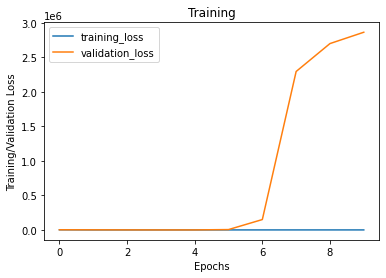

In [ ]:
## Plotting train_loss vs val_loss
plt.plot(training_points.history['loss'])
plt.plot(training_points.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('Training/Validation Loss')
plt.legend(['training_loss', 'validation_loss'])
plt.title("Training")
plt.show()

Will now be implementing the classification of emotion

In [ ]:
!ls Emotion\ AI\ Dataset


augmented.csv		icml_face_data.csv    weights_emotions.hdf5
data.csv		models.config	      weights.h5
detection.json		server.log	      weights.hdf5
emotion.json		test.csv	      weights_keypoint.hdf5
face_detection.json	training.csv
facial_detection.ipynb	weights_emotion.hdf5


In [10]:
## Loading up the dataset
## Note these images are in form 64x64
expression_df = pd.read_csv('Emotion AI Dataset/icml_face_data.csv')

In [11]:
expression_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [12]:
## Need to reshape the df to 64x64 and add it as a new column
expression_df['image'] = expression_df[' pixels'].apply(lambda x: np.fromstring(x, dtype= np.float32,  sep= ' ').reshape(48,48,1))
expression_df.head()

,emotion,pixels,image
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,"[[[70.0], [80.0], [82.0], [72.0], [58.0], [58...."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,"[[[151.0], [150.0], [147.0], [155.0], [148.0],..."
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,"[[[24.0], [32.0], [36.0], [30.0], [32.0], [23...."
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,"[[[20.0], [17.0], [19.0], [21.0], [25.0], [38...."
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,"[[[77.0], [78.0], [79.0], [79.0], [78.0], [75...."


In [13]:
## Resizing the image into a 96x96 format
expression_df['resized_image'] = expression_df['image'].apply(lambda x: cv2.resize(x.reshape(48,48), dsize=(96,96), interpolation=cv2.INTER_CUBIC))

In [14]:
## Confirming that the image was resized properly
expression_df['resized_image'][0].shape 

(96, 96)

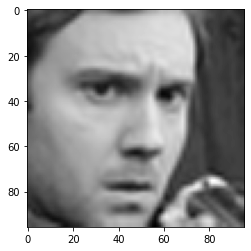

In [15]:
plt.imshow(expression_df['resized_image'][0], cmap='gray')
plt.show()

In [16]:
expression_df.shape

(24568, 4)

In [17]:
expression_dropped_df = expression_df[['emotion', 'resized_image']]

In [18]:
expression_dropped_df.shape

(24568, 2)

In [19]:
## Checking for null values
expression_dropped_df.isnull().sum()

emotion          0
resized_image    0
dtype: int64

In [20]:
## labels for the model
labels = {0: 'anger', 1: 'disgust', 2: 'sad', 3: 'happiness', 4: 'surprise'}
labels

{0: 'anger', 1: 'disgust', 2: 'sad', 3: 'happiness', 4: 'surprise'}

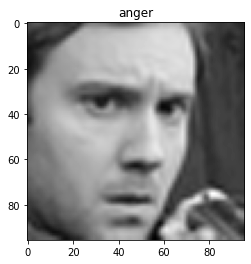

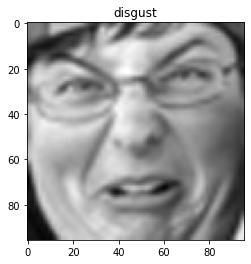

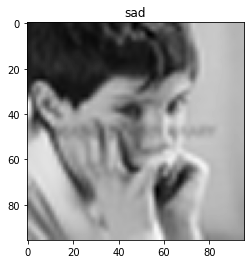

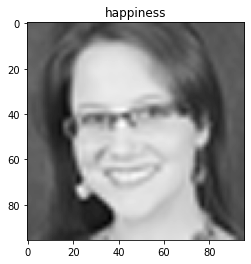

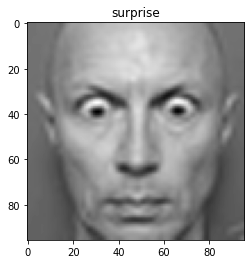

In [21]:
for index in labels:
  image = expression_dropped_df[expression_dropped_df['emotion'] == index][:1]
  img = image['resized_image'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(labels[index])
  plt.imshow(img, cmap='gray')

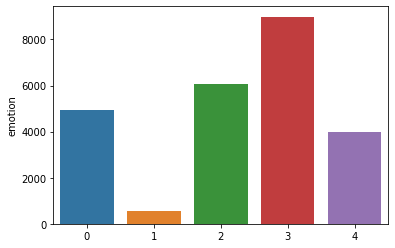

In [22]:
fig = plt.figure()
##expression_dropped_df.emotion.value_counts()[0:4]
sns.barplot(expression_dropped_df.emotion.value_counts().index, expression_dropped_df.emotion.value_counts())
## It looks like the data is unbalanced, especially for class 1. This will be fixed with augmentation

In [23]:
## Splitting up the data into features and labels
X_features = expression_dropped_df['resized_image']
Y_labels = to_categorical(expression_dropped_df.emotion) ## Essentially one-hot encoding

X_features = np.stack(X_features, axis = 0)
X_features = X_features.reshape(expression_dropped_df.shape[0], 96, 96, 1)

print(X_features.shape, Y_labels.shape)

(24568, 96, 96, 1) (24568, 5)


In [ ]:
X_features

In [25]:
Y_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [33]:
## Creating training set
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_labels, test_size = 0.4, shuffle= True)

In [34]:
## Creating validation set by splitting the test set in half
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, shuffle = True)

In [35]:
print(X_train.shape, X_test.shape, X_val.shape)

(14740, 96, 96, 1) (4914, 96, 96, 1) (4914, 96, 96, 1)


In [36]:
## Normalizing the pixel values
X_train = X_train/255.
X_test = X_train/255.
X_val = X_val/255.

In [40]:
augmentation = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    brightness_range = [1.2, 2],
    rescale = 0.1

)